# 5 Train a classifier on the STL-10 dataset
In this notebook, we will again implement a classifier in Pytorch, with the difference that this time we will use a CNN instead of an MLP for classification. The dataset we will use is the STL-10 dataset. The STL-10 dataset contains images of airplanes, birds, cats, and more, each with a resolution of $96 \times 96$ pixels. We chose this dataset so that the training would run on lower performance computers, e.g. those without a graphics card.

However, classifiers do not work with the textual description of objects like "Airplane", "Bird", "Car" etc. instead each class is represented with a number. We define this representation first, as this will make things easier for us later. For this we choose the lexicographic sorting of the class names and index according to this order. We store the result in a dictionary (a list would also be sufficient).

## 1. Read the Data

In [14]:
import os
import numpy as np
import random
import glob
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.transforms import v2
from torch.utils.data import Dataset

from PIL import Image
import cv2

from tqdm import tqdm   # Progress-Bar

# Setze einen Seed für die Reproduzierbarkeit.
torch.manual_seed(1)

class_map_idx_to_str = {0: 'airplane',
                        1: 'bird', 
                        2: 'car', 
                        3: 'cat', 
                        4: 'deer', 
                        5: 'dog', 
                        6: 'horse', 
                        7: 'monkey', 
                        8: 'ship', 
                        9: 'truck'}


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False

seed_everything(1)

# Define the path to the folders train, val und test.
root_dir = "/kaggle/input/stl-10-dataset/STL-10_Dataset"

# Define a path to a folder containing trained weights.
checkpoint_path = "/kaggle/working/Checkpoint/last.pth.tar"

#If the checkpoints folder does not already exist create a new one
if not os.path.isdir(os.getcwd() + "/Checkpoint/"):
    os.makedirs(os.getcwd() + "/Checkpoint/")

# Load the current checkpoint (if existinoiutg), otherwise create a new one.
def create_or_load_checkpoint(model, epoch=-1, optimizer=None, last_loss=10**20):
    
    if os.path.isfile(checkpoint_path):
        print("=> Looking for checkpoint")
        try:
            checkpoint = torch.load(checkpoint_path)
            
            epoch = checkpoint['epoch']
            print("Loaded epoch number is", epoch)            
            last_loss = checkpoint['best_loss']
            print("Loaded best loss is", last_loss)
            model.load_state_dict(checkpoint['state_dict'], strict=False)
            # model.conv1.load_state_dict(checkpoint['state_dict']['conv1.weight'])
            print("Best Model Weights loaded")
            if not optimizer is None:
                optimizer.load_state_dict(checkpoint['optimizer'])
            print("=> Found and loaded checkpoint")
        except:
            print("Your checkpoint does not contain trained weights. Your old weights will be overwritten.")
            torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'best_loss': last_loss, 'optimizer': optimizer.state_dict()}, checkpoint_path)
    else:
        torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'best_loss': last_loss, 'optimizer': optimizer.state_dict()}, checkpoint_path)
        print("=> No checkpoint found. You have to train first.")
    return epoch, last_loss

## 2. Bilder laden und Exkurs zu Augmentierungen (ToDo + Bonusaufgabe)
Im folgenden Abschnitt laden wir die Bilder. Wenn Sie die Bonusaufgabe machen möchten, sollen die Bilder nicht mehr nur im originalen Zustand dem Training übergeben werden, sondern die Bilder sollen zovor augmentiert werden. Das heißt, die Bilder sollen mit einer Wahrscheinlichkeit von:
 * 75% rotiert werden. Die Rotation soll im Bereich -15 bis +15 Grad liegen. (2 Punkte)
 * 50% an der vertikalen Achse gespiegelt werden. (1 Punkt)

Weitere gängige Augmentierungsmethoden, die Sie freiwillig implementieren können, sind z.B.
1. Änderung in Helligkeit, Sättigung und Farbwert: verwende HSV statt RGB und ändere H (Hue), S (Saturation) und V (Value)
2. Verschiebung: Bild wird etwas nach oben, unten, links oder rechts verschoben.
3. Skalierung: Bild wird vergrößert oder verkleinert
4. Scherung: Bild wird geschert: Eine Seite bleibt fest, die gegenüberliegende Seite wird verschoben
5. Crops: Statt dem gesamten Bild werden dem Modell nur Teile des Bildes gezeigt (meist zufällige Bildausschnitte und mehrere)
6. Rauschen: Auf das Bild wird ein verrauschtes Array addiert

Die Idee der Augmentierung ist, dass man künstlich die Anzahl der Eingabebilder vergrößert. Mittlerweile ist man so weit, dass man neuronale Netze verwendet, sogenannte GANs (Generative Adversarial Network), die für einen gegebenen Datensatz, die Verteilung dieses Datensatzes lernen. Dadurch lassen sich ähnliche, täuschend echte Bilder erzeugen, die wiederum für ein anderes Netz verwendet werden können. Diese Technik verwendet man häufig bei Daten für die es sehr schwer ist gelabelte Daten zu bekommen, z.B. Sensordaten für Aktivitätserkennung.

In [15]:
class Simple_Dataloader(Dataset):
    def __init__(self, root_dir, loader_mode):
        self.root_dir = root_dir
        self.loader_mode = loader_mode
        self.imgs = []
        for i in range(10):
            self.imgs += glob.glob(root_dir + os.sep + loader_mode + os.sep + class_map_idx_to_str.get(i) + '/*.png')

        self.transform = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.RandomRotation(15),
            v2.RandomHorizontalFlip(p=0.5),
            v2.ColorJitter(brightness=0.5, saturation=0.3, hue=0.3),
            v2.RandomAffine(degrees=0, translate=(0.12, 0.12), shear=15),
            v2.RandomResizedCrop(size=(96,96), scale=(0.7, 1.2),antialias=True),
        ])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx] # get the path of the image
        img = Image.open(img_path)  # open the Image/
        
        #Transform our PIL image to a tensor and apply augmentations
        img_torch = self.transform(img)

        label = os.path.basename(os.path.dirname(self.imgs[idx])) # get the lbl e.g('airplane')
        label_num = next(key for key, value in class_map_idx_to_str.items() if value == label) # get the numerical label

        return img_torch, torch.tensor(int(label_num))


## 2. Dataset zu Dataloader (nothing ToDo)
Wir übergeben das Dataset dem Dataloader.

In [16]:
batch_size_train = 32# 88
batch_size_val = 1

print("Cache Data:")

train_dataset = Simple_Dataloader(root_dir=root_dir, loader_mode="train")
val_dataset = Simple_Dataloader(root_dir=root_dir, loader_mode="val")
test_dataset = Simple_Dataloader(root_dir=root_dir, loader_mode="test")


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, pin_memory=True,
                                               shuffle=True, drop_last=False)

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size_val, pin_memory=True,
                                             shuffle=False, drop_last=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, pin_memory=True,
                                              shuffle=False, drop_last=False)

dataset_sizes = dict()
dataset_sizes["train"] = len(train_dataset.imgs)
dataset_sizes["val"] = len(val_dataset.imgs)
dataset_sizes["test"] = len(test_dataset.imgs)
dataset_sizes

Cache Data:


{'train': 4250, 'val': 250, 'test': 500}

In [17]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    print(img.shape)
    npimg= img.squeeze(0).numpy()
    print(npimg.shape)
    t_imag= np.transpose(npimg, (1, 2, 0))
    print(t_imag.shape)
    plt.figure(figsize =(5,5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
    plt.show()

#dataiter = iter(test_dataloader)
#images, labels = next(dataiter)
#number = labels.item()
#imshow(torchvision.utils.make_grid(images))
#labels = [class_map_idx_to_str[number.item()] for number in labels]

# Print the labels
#print("Labels:", labels)

## 3. Plotten von Zwischenergebnissen (nothing ToDo)
Später, während des Trainings und der Validierung, möchten wir gerne einige Zwischenergebnisse sehen. Hierfür verwenden wir die nachfolgende Methode. Dabei wird in Ihrem Verzeichnis ein Ordner mit dem Namen *Some Results [YYYY-MM-DD HH_MM_SS]* (Zeitstempel kommt von oben) angelegt. Darin finden Sie nach ausreichend langem Training, zwei Unterordner *train* und *val*. Beide Unterordner enthalten die Zwischenergebnisse. Die Dateinamen sehen wie folgt aus:
  
<br>
<center>Epoch_e;cls_i.png</center>

und bedeuten, dass das gezeigte Bild in der Epoche e, Iteration i, als Klasse cls klassifiziert wurde.
<br>  
<br>  
<br>  

### 3.1 Pytorch Tensoren und ihre Dimensionsreihenfolge (nothing ToDo)
Ein Pytorch Tensor hat in der Regel folgende shape:

<br>
<center>[batch_size, num_channels, height, width]</center>

Das heißt, um ein RGB Bild zu plotten müssen wir uns erst einmal für einen Batchindex entscheiden. Um unnötigen Ärger mit nichtvorhandenen Indizes zu vermeiden, wählen wir im nächsten Abschnitt *batch_idx = 0*, somit bekommen wir auch keinen Fehler, selbst wenn wir mit einer Minibatch von *batch_size = 1* trainieren. Folglich ist *inp* von der Form:

<br>
<center>[num_channels, height, width]</center>

Ein weiterer Unterschied bezüglich der Dimensionsreihenfolge zwischen der Pytorch Tensoren und numpy Arrays ist, dass bei numpy Arrays die Channels am Ende stehen. Um diese Reihenfolge anzupassen, verwenden wir im folgenden:

<br>
<center>inp.transpose((1, 2, 0))</center>

Das heißt die erste Dimension wird an die nullte Dimension, die zeite Dimension an die erste Dimension und die nullte an die zweite Dimension verschoben. Oft spricht man auch von *channel first* oder *channel last*.

<br>
Da die Pytorch Tensoren Float-Tensoren sind, enthalten die Channels Werte zwischen 0 und 1. Wenn wir aber mit PIL (Pillow) ein Bild speichern möchten, müssen wir den Tensor zu einem uint8 Format casten (Restklassenring Z/256Z) und sicherstellen, dass die Werte zwischen 0 und 255 liegen.

In [18]:
def plot_some_results(inputs, preds, class_map, img_counter, epoch, phase):
    batch_idx = 0
    
    # Den Teil ".cpu().detach()" brauchen wir hier nicht unbedingt, da wir nicht auf einer Grafikkarte arbeiten.
    # Könnte aber für alle interessant sein, die das Zuhause auf ihrem eigenen PC mit GPU Unterstüzung laufen lassen.
    inp = np.array(inputs.cpu().detach().numpy()[batch_idx], dtype=np.float32)
    
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]
   
    
    # Da die Bilder zuvor normalisiert wurden, müssen wir dies erst rückgängig machen.
    for channel in range(3):
        inp[channel] = inp[channel] * stds[channel] + means[channel]
        inp[channel] = np.minimum(np.maximum(inp[channel], 0), 1)    
    
    inp = np.array(inp.transpose((1, 2, 0)) * 255.0, dtype=np.uint8)
    class_name = class_map[int(preds[batch_idx])]

    save_dir_results = os.getcwd() + os.sep + "Results" + os.sep + phase + os.sep

    if not os.path.isdir(save_dir_results):
        os.makedirs(save_dir_results)
    
    save_path = save_dir_results + "Epoch_" + str(epoch) + ";" + class_name + "_" + str(img_counter) + ".png"
    cv2.imwrite(save_path, inp)
    img_counter += 1

## 4. Convolutional Neural Network definieren (ToDo)
Im folgenden betrachten wir drei Modelle

0. Small_Model
1. Our_First_CNN
2. ResNet34

Das *Small_Model* soll Ihnen Hilfestellung geben, wie ein CNN implementiert werden kann. Dabei wurden einige aus der Vorlesung bekannte Konzepte wie z.B. die Convolution Operation (```nn.Conv2d```), Dropout (```nn.Dropout```), Fully-Connected-Layer (```nn.Linear```), Pooling-Layer (z.B. Max-Pooling ```nn.MaxPool2d```) und eine Aktivierungsfunktion (z.B. ```nn.ReLU```) verwendet.

Das *ResNet34* ist ein vordefiniertes CNN mit dem oft erstaunlich gute Ergebnisser erzielt werden können. Es soll als Vergleichsmodell dienen.

Außerdem gibt es noch das *Our_First_CNN*. Sie können diese Klasse als Vorlage verwenden um ihr eigenes CNN zu implementieren. 

<br>  
Bei vordefinierten Modellen wie z.B. AlexNet, ResNet oder GoogleNet können wir vortrainierte Gewichte verwenden. Das tolle an vortrainierten Modellen bzw. Gewichten ist, dass es keine große Rolle spielt ob sie zuvor ähnliche Objekte gesehen haben. Wir könnten z.B. ein Modell auf verschiedene Hundearten vortrainieren und später verwenden um das gleiche Modell zu verwenden um Schiffe von Autos zu unterscheiden. Diese Technik nennt sich Transfer-Learning. Der Grund, weshalb das funktioniert liegt daran, dass tiefe Netze viele verschiedene Arten von Features lernen. Diese Feature können wenig komplex sein z.B. Linien und Kurven (häufig in den ersten Layern) bis hin zu sehr komplexen Features wie z.B. die Schnautze eines Labradors oder die Ohren eines Luchses (oft in den letzten Layern).

Wenn Sie also ein anderes vordefiniertes Modell ausprobieren möchten sollten Sie den Parameter `pretrained` auf `True` setzen. Die Datensätze auf denen zuvor trainiert wurde, haben meist nicht die gleiche Anzahl an Klassen, wie wir sie benötigen. Daher schneiden wir den letzten Layer ab und setzen einen neuen Layer mit der von uns benötigten Anzahl an Klassen bzw Neuronen dran. Der letzte Layer ist bei Klassifizierern in der Regel ein Fully-Connected Layer. Die neu zugewiesene Gewichte kennen wir natürlich nicht und wählen daher eine zufällige Belegung.

### ToDo
Ihre Aufgabe ist es also die Klasse *Our_First_CNN* so zu implementieren, dass ein Modell entsteht das besser ist als das *Small_Model*.

In [19]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

which_model = 1

class Small_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(5, 5), stride=(1, 1), padding=(0, 0), bias=False)
        self.dropout = nn.Dropout(0.33)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 46 * 46, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.dropout(self.conv1(x))))
        x = torch.flatten(x, 1) # flatte alle Dimensionen außer der Batch
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    
class Our_First_CNN_VGG(nn.Module):
    def __init__(self):
        super().__init__()
        #96 x 96 x 3
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), stride= 1, padding=(1, 1), bias=False) # 96 x 96 x 64
        self.bn1_1 = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride= 1, padding=(1, 1), bias=False) # 96 x 96 x 64
        self.bn1_2 = nn.BatchNorm2d(64)
        
        self.dropout1 = nn.Dropout(0.25)
        
        self.conv2_1= nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride= 2, padding=(1, 1), bias=False) # 48 x 48 x 128
        self.bn2_1 = nn.BatchNorm2d(128)
        self.conv2_2= nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride= 1, padding=(1, 1), bias=False) # 48 x 48 x 128
        self.bn2_2 = nn.BatchNorm2d(128)
        self.downsample2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(128),
        )
        
        self.dropout2 = nn.Dropout(0.25)
       
        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride= 2, padding=(1, 1), bias=False) # 24 x 24 x 256
        self.bn3_1 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride= 1, padding=(1, 1), bias=False)# 24 x 24 x 256
        self.bn3_2 = nn.BatchNorm2d(256)
        
        self.downsample3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(256),
        )
        
        self.dropout3 = nn.Dropout(0.3)
        
        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride= 2, padding=(1, 1), bias=False)# 12 x 12 x 512
        self.bn4_1 = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride= 1, padding=(1, 1), bias=False)# 12 x 12 x 512
        self.bn4_2 = nn.BatchNorm2d(512)
        self.downsample4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(512),
        )
        self.dropout4 = nn.Dropout(0.4)
        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride= 1, padding=(1, 1), bias=False) # 12 x 12 x 512
        self.bn5_1 = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride= 1, padding=(1, 1), bias=False) # 12 x 12 x 512
        self.bn5_2 = nn.BatchNorm2d(512)
    
        self.pool = nn.MaxPool2d(2, 2) # 48 x 48 x 64# 6 x 6 x 512
        self.dropout5 = nn.Dropout(0.5)
    
        
        self.dropout6 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(512 * 6 * 6, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 10)
        
        

    def forward(self, x):
        x = torch.relu(self.bn1_1(self.conv1_1(x)))
        x = torch.relu(self.bn1_2(self.conv1_2(x)))
        
        #x = self.dropout1(x)
        
        identity2 = self.downsample2(x)
        x = torch.relu(self.bn2_1(self.conv2_1(x)))
        x = self.bn2_2(self.conv2_2(x))
        x += identity2
        x = torch.relu(x)
        
        #x = self.dropout2(x)
        
        identity3 = self.downsample3(x)
        x = torch.relu(self.bn3_1(self.conv3_1(x))) 
        x = self.bn3_2(self.conv3_2(x))
       
        x += identity3
        x = torch.relu(x)
        
        #x = self.dropout3(x)

        identity4 = self.downsample4(x)
        x = torch.relu(self.bn4_1(self.conv4_1(x)))
        x = self.bn4_2(self.conv4_2(x))
    
        x += identity4
        x = torch.relu(x)
        
        #x = self.dropout4(x)
        
        identity5 = x
        x = torch.relu(self.bn5_1(self.conv5_1(x)))
        x = self.bn5_2(self.conv5_2(x))
        x += identity5
        x = torch.relu(x)
        
        x = self.pool(x)# 6 x 6 x 512
        #x = self.dropout5(x)

        x = torch.flatten(x, 1) 
        x = torch.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout6(x)
        x = self.fc2(x)
        return x

    
def resnet34(num_classes=10):
    # Lade das ResNet34
    model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
    
    # Die Anzahl der eingehenden Neuronen in den letzten Layer des ResNet34 werden in der Variable num_features gespeichert.
    num_features = model.fc.in_features
    
    # Ändere die Anzahl ausgehender Neuronen im letzten Layer des ResNet34, indem ein neuer Fully-Connected Layer 
    # zugewiesen wird.
    model.fc = torch.nn.Linear(num_features, num_classes)  # First fully connected layer with 100 output unit
    
    return model



## 5. Implementieren der Trainingsmethode (ToDo)
Im folgenden sollen Sie die Trainingsmethode implementieren. 
Hinweis: Sie können im Prinzip die Trainingsmethode aus dem letzen Übungsblatt verwenden und Kleinigkeiten anpassen, wie z.B. das verwendete Modell. Auch folgenden Tutorials könnten hilfreich sein:
1. [Ein Tutorial über Transferlearning, am Beispiel von Bienen und Ameisen](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#training-the-model)
2. [Training eines Klassifizierers, am Beispiel von Cifar10](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#train-the-network)

In [22]:
model = None

if which_model == 0:
    model = Small_Model()
elif which_model == 1:
    model = Our_First_CNN_VGG()
else:
    model = resnet34(num_classes=len(class_map_idx_to_str))
    

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())
count_parameters(model)

19025610

In [24]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print, best_score=None):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = best_score
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, epoch,val_loss, optimizer, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch,val_loss, optimizer, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(epoch,val_loss, optimizer, model)
            self.counter = 0

    def save_checkpoint(self, epoch,val_loss, optimizer, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func('')
            self.trace_func('---------********************************----------')
            self.trace_func('----------New best model found and saved.----------')
            self.trace_func('---------********************************----------')
            self.trace_func('')
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        #torch.save({'epoch': epoch, 'state_dict': model.state_dict(),'best_loss': val_loss, 'optimizer': optimizer.state_dict()},self.path)
        self.val_loss_min = val_loss

In [25]:
import torch.optim as optim
from torch.optim import lr_scheduler
import sys
import copy
import multiprocessing


num_cores = multiprocessing.cpu_count()
print(f"Number of CPU cores available: {num_cores}")


# Wenn Sie eine NVIDIA Grafikkarte besitzen und CUDA installiert ist, können Sie diesen Wert zu "cuda" ändern.
#device = "cpu"
device = "cuda"


def train_model(model, num_epochs=100):
    best_eval_loss =  sys.float_info.max
    #best_eval_loss = 0.8887 # with adamW lr=0.000005,weight_decay=0.05
    #best_eval_loss = (0.2166,0.8917) with sgd, lr=0.00005, momentum=0.9
    #best_eval_loss = (0.4550,0.8831) with sgd, lr=0.000005, momentum=0.9
    
    #best_eval_loss = 0.69,  lr=0.0005, momentum=0.9,
    #best_eval_loss = 0.68 lr=0.0005, momentum=0.9 wd= 0.001,
    #best_eval_loss = 0.68 lr=0.0001, momentum=0.9 wd= 0.01,
    #optim.AdamW(model.parameters(), lr=0.0001,weight_decay=0.3) loss(0.2663,0.6663) acc 75% highest so far
    dataloader = {'train': train_dataloader,'eval':val_dataloader}
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.3)
    #optimizer= optim.Adam(model.parameters(), lr=0.0001) 
    
    #optimizer= optim.AdamW(model.parameters(), lr=0.00001,weight_decay=1)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=8, factor=0.1, min_lr=0.00001)
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.01)
    
    #load resnet best weights (model, epoch=-1, optimizer=None, last_loss=10**20):
    epoch, last_loss = create_or_load_checkpoint(model,-1)
    #set the best eval loss
    best_eval_loss = last_loss
    
    #path to current model
    early_stopping = EarlyStopping(30,verbose=True, path='/kaggle/working/Checkpoint/new.pth.tar',best_score=-best_eval_loss)
    
    
    
    #leverage kaggle gpus
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
        #model = nn.DataParallel(model)     
        

    for epoch in range(num_epochs):
        
        
        if early_stopping.early_stop:
            print("Early stopping")
            break

        for phase in ['train','eval']:
            if phase == 'train':
                 model.train()    
            else:
                model.eval()
                
            running_loss = 0
           
            for inputs, labels in tqdm(dataloader[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() # zero the parameter gradients
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) #forward propagation

                    loss = criterion(outputs, labels) #calculate the loss

                    if phase == 'train': 
                        loss.backward()   # backpropagation
                        optimizer.step() #update the weights
                running_loss += loss.item() # update the running_loss
            
            loss = running_loss/ len(dataloader[phase])
            print(f'Epoch {epoch + 1} {phase} loss: {loss:.4f}')
            if phase == 'eval':
                scheduler.step(loss)
                #scheduler.step()
                print('')
                print(f"Learning rate {optimizer.param_groups[0]['lr']}")
                early_stopping(epoch,loss,optimizer,model) # early stopping using eval loss
                
           
        

Number of CPU cores available: 4


In [26]:
train_model(model,10)

=> Looking for checkpoint
Loaded epoch number is 14
Loaded best loss is 0.5946564374397713
Best Model Weights loaded
=> Found and loaded checkpoint


100%|██████████| 133/133 [00:38<00:00,  3.44it/s]


Epoch 1 train loss: 0.3679


100%|██████████| 250/250 [00:02<00:00, 90.31it/s]


Epoch 1 eval loss: 0.6944

Learning rate 0.0001
EarlyStopping counter: 1 out of 30


100%|██████████| 133/133 [00:32<00:00,  4.05it/s]


Epoch 2 train loss: 0.3754


100%|██████████| 250/250 [00:02<00:00, 120.34it/s]


Epoch 2 eval loss: 0.7179

Learning rate 0.0001
EarlyStopping counter: 2 out of 30


100%|██████████| 133/133 [00:32<00:00,  4.12it/s]


Epoch 3 train loss: 0.3914


100%|██████████| 250/250 [00:02<00:00, 122.89it/s]


Epoch 3 eval loss: 0.6838

Learning rate 0.0001
EarlyStopping counter: 3 out of 30


100%|██████████| 133/133 [00:32<00:00,  4.10it/s]


Epoch 4 train loss: 0.3982


100%|██████████| 250/250 [00:02<00:00, 122.99it/s]


Epoch 4 eval loss: 0.6446

Learning rate 0.0001
EarlyStopping counter: 4 out of 30


100%|██████████| 133/133 [00:31<00:00,  4.16it/s]


Epoch 5 train loss: 0.4132


100%|██████████| 250/250 [00:02<00:00, 118.51it/s]


Epoch 5 eval loss: 0.6974

Learning rate 0.0001
EarlyStopping counter: 5 out of 30


100%|██████████| 133/133 [00:32<00:00,  4.13it/s]


Epoch 6 train loss: 0.4355


100%|██████████| 250/250 [00:02<00:00, 124.08it/s]


Epoch 6 eval loss: 0.6968

Learning rate 0.0001
EarlyStopping counter: 6 out of 30


100%|██████████| 133/133 [00:31<00:00,  4.21it/s]


Epoch 7 train loss: 0.4632


100%|██████████| 250/250 [00:02<00:00, 115.99it/s]


Epoch 7 eval loss: 0.7420

Learning rate 0.0001
EarlyStopping counter: 7 out of 30


100%|██████████| 133/133 [00:31<00:00,  4.17it/s]


Epoch 8 train loss: 0.5012


100%|██████████| 250/250 [00:02<00:00, 122.27it/s]


Epoch 8 eval loss: 0.7553

Learning rate 0.0001
EarlyStopping counter: 8 out of 30


100%|██████████| 133/133 [00:32<00:00,  4.14it/s]


Epoch 9 train loss: 0.5349


100%|██████████| 250/250 [00:02<00:00, 118.08it/s]


Epoch 9 eval loss: 0.7739

Learning rate 0.0001
EarlyStopping counter: 9 out of 30


100%|██████████| 133/133 [00:31<00:00,  4.22it/s]


Epoch 10 train loss: 0.5579


100%|██████████| 250/250 [00:02<00:00, 116.94it/s]

Epoch 10 eval loss: 0.8029

Learning rate 0.0001
EarlyStopping counter: 10 out of 30


## 6. Evaluieren des trainierten Modells (ToDo)
Vervollständigen Sie die Methode test_classifier() so, dass eine Confusion Matrix für alle Testbilder berechnet und visualsiert wird. In *all_imgs* sind alle Pfade zu den Testbildern zu finden.  

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix


def testy_model(model, test_dataset):
    # Set model to evaluation mode
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # Initialize lists to store the true labels and predictions
    true_labels = []
    pred_labels = []
    # Iterate over the data
    for inputs, labels in tqdm(test_dataset):
        # Move data to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            # Get model predictions
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            # Append true labels and predictions to the lists
            true_labels.append(labels.item())
            pred_labels.append(preds.item())
    # Convert the lists to numpy arrays
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)
    # Compute the confusion matrix
    accuracy = (true_labels == pred_labels).mean()
    print(f'the accuracy is {accuracy *100}')
    cm = confusion_matrix(true_labels, pred_labels)
    return cm

## 7. Training und Valdierung starten (ToDo)
Starten Sie nun das Training.

In [28]:
#res = torch.load("/kaggle/working/Checkpoint/last.pth.tar")
#print(res['best_loss'])
#model = resnet34(num_classes=len(class_map_idx_to_str))
#model.load_state_dict(res['state_dict']) 

#create_or_load_checkpoint(model)
cm = testy_model(model, test_dataloader)

100%|██████████| 500/500 [00:05<00:00, 93.88it/s]

the accuracy is 76.8


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataiter = iter(test_dataloader)
input, label = next(dataiter)
input = input.to(device)
class_labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

with torch.no_grad():
    output = model(input)
    some,pred = torch.max(output,1)
    print(f'actual label {class_labels[label]} predicted label {class_labels[pred]}')

actual label Airplane predicted label Airplane


Testen Sie Ihr Model.

## 8. Metriken berechnen (ToDo)
Berechnen Sie die Precision, Recall und $F_1$-Score und visualisieren Sie die Confusion Matrix.

100%|██████████| 500/500 [00:04<00:00, 121.87it/s]


the accuracy is 75.4


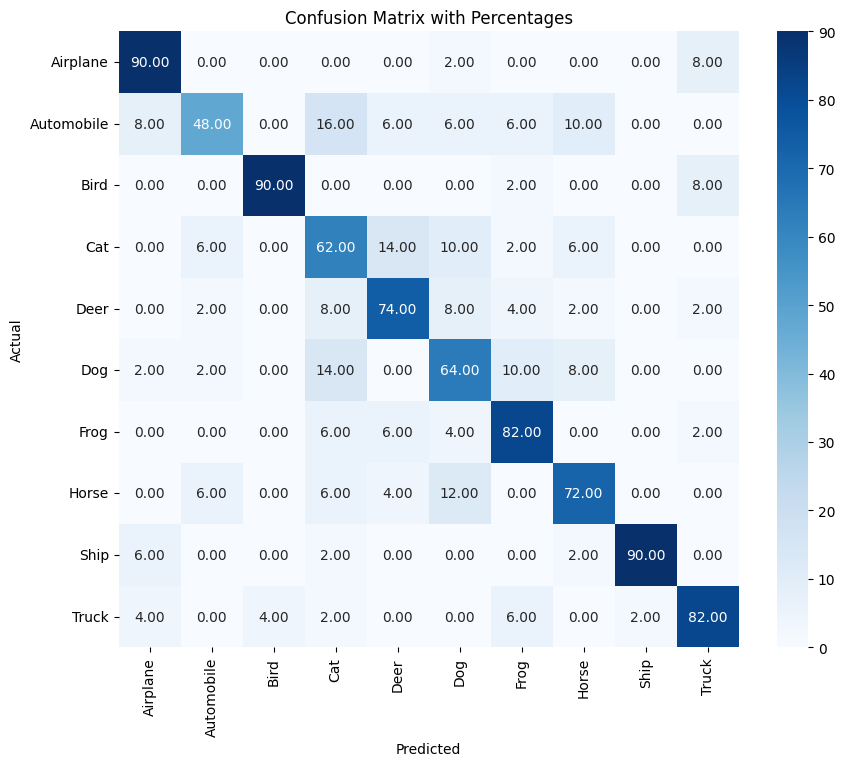

In [30]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Your confusion matrix
confusion_matrix = testy_model(model,test_dataloader)
class_labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Calculate the percentages
confusion_matrix_percent = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_percent, annot=True, fmt=".2f", cmap="Blues", cbar=True, xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix with Percentages')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
